## Beam_Stability:  
### Variations of Offset Sources with UVSPEC


August 10, 2018
D.J. Pisano

This module can be used to look at the variations in flux and phase vs. time and frequency for a source that is not at the pointing center of a beam.  It does this using the Miriad task _uvspec_ to shift the phase center and extract a spectrum.

##### *It is designed to work on a calibrated dataset.*  This notebook does *not* do any calibration.

First, we will load apercal and start the log.

In [1]:
import os;
myusername = os.environ['USER']
if not ('PYTHONPATH' in os.environ and
        '/home/' + myusername + '/apercal' in os.environ['PYTHONPATH']):
      print("WARNING: your apercal directory should be in the $PYTHONPATH")

%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/{}/testing/logs/beam_stability_uv.log'.format(myusername))

cfgfile='/home/{}/testing/cfg/bm_stability.cfg'.format(myusername)
logpath='/home/{}/testing/logs/'.format(myusername)

import apercal


/home/apercal/pipeline/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/pisano/testing/logs/beam_stability_uv.log


Setup logger with lib.setup_logger()


This script is designed to work on data that has already been reduced.  You will need to specify the beam of interest, out of those that have been processed.  

In [2]:
preflag = apercal.preflag(cfgfile)

Now that we have a calibrated dataset, we want to see how the flux and phase vary over time for a source as compared to its average value.  First we need the coordinates of a source, and the beam phase center.  

In [4]:
filename=preflag.target.replace('MS','mir')
uvfile=(preflag.basedir+str(preflag.beam)+'/crosscal/'+filename)
print(uvfile)

# Use Miriad task to extract RA, Dec of phase center.
uvlist=lib.miriad('uvlist')
uvlist.vis=uvfile
uvlist.options='source'
uvlist.log=preflag.basedir+'/source.log'
uvlist.go()

# Extract the RA, Dec of the beam pointing center
with open(logpath+'/source.log') as f:
    tmp_text=f.readlines()
f.close()
RAc=tmp_text[6][5:16]
Decc=tmp_text[7][5:16]

RAc=RAc.replace(':','h',1)
RAc=RAc.replace(':','m',2)
RAc=RAc+'s'

Decc=Decc.replace(':','d',1)
Decc=Decc.replace(':','m',2)
Decc=Decc+'s'

# Convert to SkyCoord
from astropy.coordinates import SkyCoord  # High-level coordinates

ptg=SkyCoord(RAc,Decc)

print(ptg)

/data4/pisano/m31/00/crosscal/M31.mir
<SkyCoord (ICRS): (ra, dec) in deg
    (10.68458333, 41.26919444)>


In [5]:
from astropy import units as u

# Enter the RA,Dec of the source of interest as a string in the format below:
#RAs='00h42m18.368s'
#Decs='41d29m22.85s'
RAs='00h42m18.368s'
Decs='41d29m22.85s'

src=SkyCoord(RAs,Decs)

# Calculate the difference between the positions in arcsec
dRA,dDec=ptg.spherical_offsets_to(src)

dRA=dRA.to(u.arcsec).value
dDec=dDec.to(u.arcsec).value

offsets="'{0},{1}'".format(dRA,dDec)

print('dRA, dDec in arcsec: ',offsets)


('dRA, dDec in arcsec: ', "'-291.377296374,793.931220338'")


Now we will pick some averaging time intervals

In [6]:
#Enter the solution time in minutes here.
tsolve=1000.   # This is the timescale over which the reference spectrum is calculated. 

#Enter the time scale over which you'd like to examine variations in amplitude and phase
tint=60.  # This is in minutes

Now we can use UVSPEC to extract an average spectrum for the entire observation.  

In [7]:
uvspec = lib.miriad('uvspec')

uvspec.vis = uvfile
uvspec.interval = tsolve  # Plot over the entire solution interval
uvspec.stokes='ii'
uvspec.axis='frequency,amplitude'
uvspec.options='nobase,avall'
uvspec.log=logpath+'contsrc_12h.log'
uvspec.offset=offsets

uvspec.go()

['UvSpec: version 1.0 21-Apr-10',
 'Applying bandpass corrections to /data4/pisano/m31/00/crosscal/M31.mir',
 'Applying gain corrections to /data4/pisano/m31/00/crosscal/M31.mir']

Now we will load the average bandpass into an array, plot it, and save it for reference. 

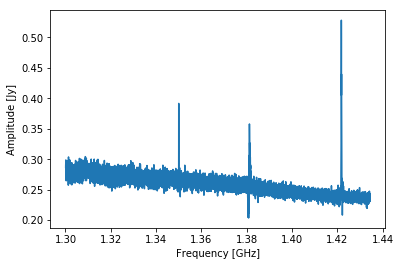

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

freq_avg=np.loadtxt(logpath+'contsrc_12h.log',float,usecols=[0])
amp_avg=np.loadtxt(logpath+'contsrc_12h.log',float,usecols=[1])
nchan=len(freq_avg)
plt.plot(freq_avg,amp_avg,'-')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Amplitude [Jy]')
plt.show()

Okay, now let's run uvspec with a shorter averaging interval and save the results to another log file, this time with a timestamp in it.  

In [9]:
uvspec = lib.miriad('uvspec')

uvspec.vis = uvfile
uvspec.interval = tint  #Averaging the calibrator over tint.
uvspec.stokes='ii'
uvspec.axis='frequency,amplitude'
uvspec.options='nobase,avall,timelog'
uvspec.log=logpath+'contsrc_tint.log'
uvspec.offset=offsets

uvspec.go()

['UvSpec: version 1.0 21-Apr-10',
 'Applying bandpass corrections to /data4/pisano/m31/00/crosscal/M31.mir',
 'Applying gain corrections to /data4/pisano/m31/00/crosscal/M31.mir']

Okay, now we need to parse this new log file so that we can extract each time interval into a separate array.  To do this, we will use the original extracted spectrum as a guide to the number of channels and their frequencies.  

We also need to know the number of intervals, which we can do with the following code:

In [10]:
def lcount(keyword, fname):
    with open(fname, 'r') as fin:
        return sum([1 for line in fin if keyword in line])

In [11]:
nint=lcount(':',logpath+'contsrc_tint.log'.format(myusername))
print("Number of time intervals: ",nint)
print("Number of channels in spectrum: ", nchan)

('Number of time intervals: ', 12)
('Number of channels in spectrum: ', 10148)


We can use grep on the uvspec_avg.log file to extract the exact times corresponding to each interval as well.

We will now use this information to parse the log file, saving each time interval to a separate log.

In [13]:
# First read the entire file into a string list
with open(logpath+'contsrc_tint.log') as f:
    tmp_text=f.readlines()
f.close()

# Now write out each interval to a separate log file.

times=[]
interval=0
linecount=np.zeros([nint],int)
for t in range(len(tmp_text)-1):
    if ':' in tmp_text[t]:
        if interval!=0:
            f.close()
        f=open(logpath+"t{}.log".format(str(interval)),"w")
        times.append(tmp_text[t].rstrip())
        interval+=1   
    else:
        linecount[interval-1]+=1
        f.write(tmp_text[t])
f.close()

Now we will convert the times into MJD to facilitate comparisons and labeling.

In [14]:
from datetime import datetime
from astropy.time import Time
t_mjd=[]
for t in range(len(times)):
    t_mjd.append(Time(datetime.strptime(times[t].rstrip(), '%y%b%d:%H:%M:%S.%f')).mjd)
    
tzero=t_mjd[0]
for t in range(len(t_mjd)):
    t_mjd[t]=(t_mjd[t]-tzero)*24.


Okay, now we create a couple of 2D arrays so we can loop through the log file and save each spectrum to a separate row.

In [15]:
# Create freq_t and amp_t arrays to hold each time interval in a separate row.  Initially they will be filled with 
# NaNs in case data is flagged in a given channel.
amp_t=np.zeros([nchan,nint],float)
amp_t.fill(np.nan)

# Now load the data from the log file into each row.
for t in range(nint):
    freq=np.loadtxt(logpath+'t{}.log'.format(str(t)),float,usecols=[0])
    amp=np.loadtxt(logpath+'t{}.log'.format(str(t)),float,usecols=[1])
    n=np.where(np.isin(freq_avg,freq))[0]
    amp_t[n,t]=amp


Okay, now we can plot these spectra and see how they compare.

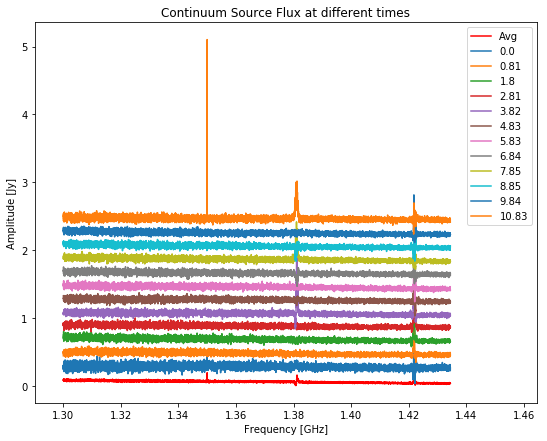

In [19]:
offset=0.2
plt.figure(figsize=(9,7))
plt.plot(freq_avg,amp_avg-offset,'r-',label='Avg')
for t in range(nint):
    plt.plot(freq_avg,amp_t[:,t]+t*offset,'-',label=round(t_mjd[t],2))
plt.xlim(np.min(freq_avg)-0.01,np.max(freq_avg)+0.03)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Amplitude [Jy]')
plt.title('Continuum Source Flux at different times')
plt.legend()
plt.show()

Now we will divide each time interval by the average amplitudes and plot those

('Time interval: ', 0, 0.0, 'Mean ratio: ', 1.0863744854482662, '+/-', 0.12548930971603517)
('Time interval: ', 1, 0.81, 'Mean ratio: ', 1.0747576796143696, '+/-', 0.09151716377472748)
('Time interval: ', 2, 1.8, 'Mean ratio: ', 1.0980456651187238, '+/-', 0.0943824302317132)
('Time interval: ', 3, 2.81, 'Mean ratio: ', 1.0908743177493068, '+/-', 0.11116349177540627)
('Time interval: ', 4, 3.82, 'Mean ratio: ', 1.0256591187545343, '+/-', 0.15706930291646218)
('Time interval: ', 5, 4.83, 'Mean ratio: ', 1.020326449791763, '+/-', 0.09353513340839312)
('Time interval: ', 6, 5.83, 'Mean ratio: ', 0.9834084887406028, '+/-', 0.08260929158683852)
('Time interval: ', 7, 6.84, 'Mean ratio: ', 1.0049466864302914, '+/-', 0.08810547695007845)
('Time interval: ', 8, 7.85, 'Mean ratio: ', 1.0184529128664728, '+/-', 0.10642286536079769)
('Time interval: ', 9, 8.85, 'Mean ratio: ', 0.9901582844209604, '+/-', 0.09412080557093175)
('Time interval: ', 10, 9.84, 'Mean ratio: ', 0.9722614954002254, '+/-', 0

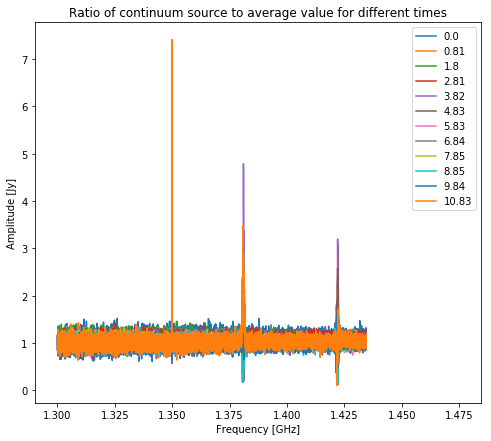

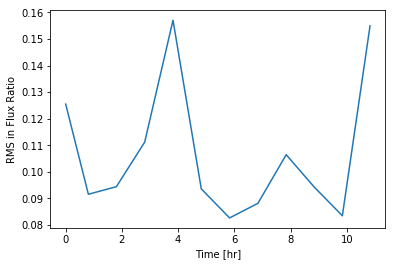

('The RMS of the ratios (averaged over all channels) is: ', 0.042252424617220605)


In [20]:
# Normalize by average amplitude of continuum source to create ratio
amp_r=np.zeros([nchan,nint],float)
amp_r.fill(np.nan)

for t in range(nint):
    amp_r[:,t]=amp_t[:,t]/amp_avg[:]

# Calculate mean and stdev for each time interval
avg=[]
unc=[]
for t in range(nint):
    avg.append(np.nanmean(amp_r[:,t]))
    unc.append(np.nanstd(amp_r[:,t]))    
    print("Time interval: ",t,round(t_mjd[t],2),"Mean ratio: ",avg[t],'+/-',unc[t])
    
# Plot each time interval
plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_avg,amp_r[:,t],label=round(t_mjd[t],2))
plt.xlim(np.min(freq_avg)-0.01,np.max(freq_avg)+0.05)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Amplitude [Jy]')
plt.legend()
plt.title('Ratio of continuum source to average value for different times')
plt.show()

plt.plot(t_mjd, unc)
plt.xlabel("Time [hr]")
plt.ylabel("RMS in Flux Ratio")
plt.show()

print("The RMS of the ratios (averaged over all channels) is: ",np.std(avg))

Finally, clean up scratch log files.

In [21]:
import subprocess
os.system('rm -f '+logpath+'t*.log')
#os.listdir('/data/{0}/BP/'.format(myusername))

0

### This section will look at various tests of Beam Stability

For starters, we are going to do some iterative smoothing of the continuum spectrum ratio.  All smoothing will be done without decimation, and will either factor into a single 64 channel subband, or be multiples of a subband.  For starters, we will do 2, 4, 8, 16, 32, 64, 128, 256, 512 channels.

[1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0]


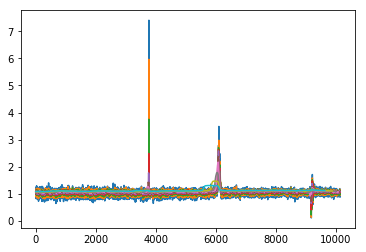

[0.15496251 0.1345673  0.11956843 0.10914163 0.10155279 0.09521957
 0.08637679 0.07248785 0.05719874 0.04380113]


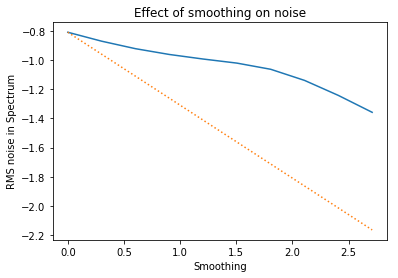

In [47]:
# Specify Smoothing factor
nsmooth=10 # Number of smooth iterations
skern=[]  # Define smoothing kernel


for i in range(0,nsmooth):
    skern.append(2.**i)
print(skern)
# Just going to look at this for the last chunk of time.
rms_time=np.zeros(nsmooth,float)
rms_theory=np.zeros(nsmooth,float)

useint=nint-1  # Should be between 0 and nint
for s in range(nsmooth):
    kern=np.ones(int(skern[s]),float)/skern[s]
    amp_s=np.convolve(amp_r[:,useint],kern,'valid')
    rms_time[s]=np.nanstd(amp_s)
    plt.plot(amp_s+s/100.)
    if s==0:
        rms_theory[s]=rms_time[s]
    else:
        rms_theory[s]=rms_theory[0]/np.sqrt(skern[s])

plt.show()

print(rms_time)
plt.plot(np.log10(skern),np.log10(rms_time))
plt.plot(np.log10(skern),np.log10(rms_theory),':')
plt.xlabel('Smoothing')
plt.ylabel('RMS noise in Spectrum')
plt.title('Effect of smoothing on noise')
plt.show()

### Dividing the Spectrum into ~ 10 MHz chunks

Okay, we want to make a similar test as we did for the BP stability.  To test this directly, we will average the spectrum over 768 channels (approx. 9.3 MHz; 12 frequency chunks)

In [23]:
df=12.20703125 # Channel width in kHz from a data cube
chanchunk=768 # Sticking with multiples of the subbands (64 channels), this is ~9.4 MHz
chunk_freq=df*chanchunk
nchunk=int(nchan/chanchunk)
print(nchunk,chunk_freq/1000.)

freq_bin=np.zeros(nchunk,float)
ratio_bin=np.zeros([nchunk,nint],float)
rms_bin=np.zeros([nchunk,nint],float)

# Now we will derive the average frequency and average ratio for each 10 MHz chunk
c1=0
c2=chanchunk
for i in range(nchunk):
    freq_bin[i]=np.nanmean(freq_avg[c1:c2])
    for t in range(nint):
        ratio_bin[i,t]=np.nanmean(amp_r[c1:c2,t])
        rms_bin[i,t]=np.nanstd(amp_r[c1:c2,t])
    c1+=chanchunk
    c2+=chanchunk

(13, 9.375)


Okay, let's look at the ratio as a function of both frequency and time:

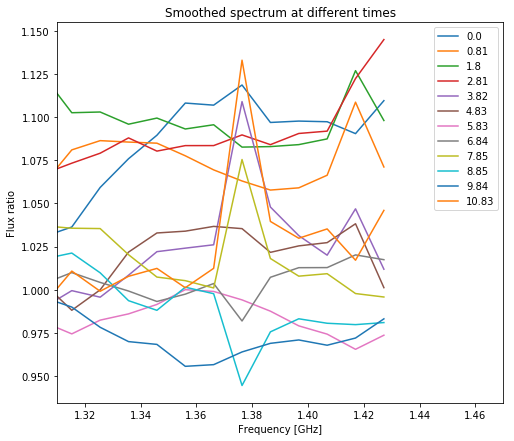

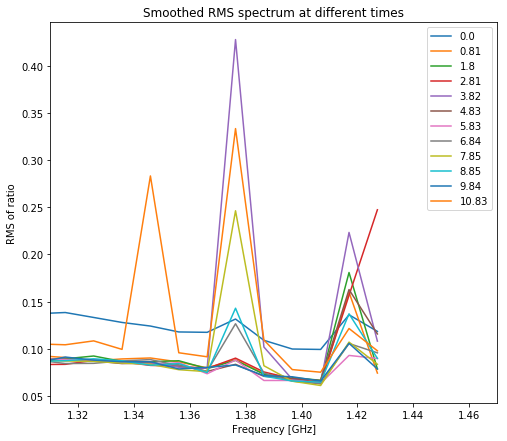

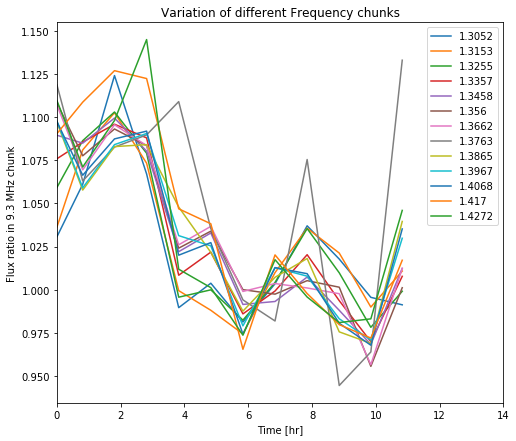

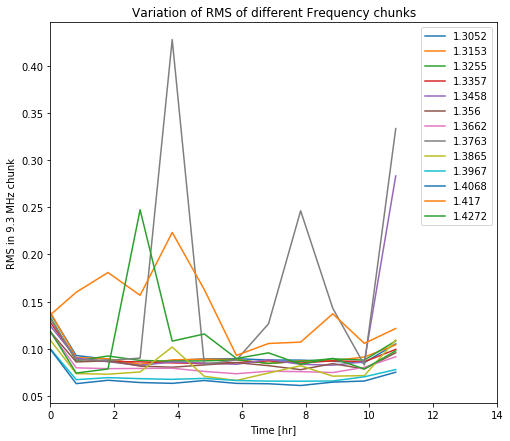

In [24]:
plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_bin,ratio_bin[:,t],label=round(t_mjd[t],2))
plt.xlabel('Frequency [GHz]')
plt.ylabel('Flux ratio')
plt.title('Smoothed spectrum at different times')
plt.xlim(1.31,1.47)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_bin,rms_bin[:,t],label=round(t_mjd[t],2))
plt.xlabel('Frequency [GHz]')
plt.ylabel('RMS of ratio')
plt.title('Smoothed RMS spectrum at different times')
plt.xlim(1.31,1.47)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for c in range(nchunk):
    plt.plot(t_mjd,ratio_bin[c,:],label=round(freq_bin[c],4))
plt.xlabel('Time [hr]')
plt.ylabel('Flux ratio in 9.3 MHz chunk')
plt.xlim(0.,14.)
plt.title('Variation of different Frequency chunks')
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for c in range(nchunk):
    plt.plot(t_mjd,rms_bin[c,:],label=round(freq_bin[c],4))
plt.xlabel('Time [hr]')
plt.ylabel('RMS in 9.3 MHz chunk')
plt.title('Variation of RMS of different Frequency chunks')
plt.xlim(0.,14.)
plt.legend()
plt.show()

In [26]:
# Calculate the RMS variation with time of each 10 MHz chunk
rms=[]
for c in range(nchunk):
    rms.append(np.std(ratio_bin[c,:]))
    print('RMS variation of ratio in frequency chunk ',c,' is ',rms[c])

print('Mean RMS is ',np.mean(rms))

('RMS variation of ratio in frequency chunk ', 0, ' is ', 0.040013667724297375)
('RMS variation of ratio in frequency chunk ', 1, ' is ', 0.038664862074674046)
('RMS variation of ratio in frequency chunk ', 2, ' is ', 0.041636715621652096)
('RMS variation of ratio in frequency chunk ', 3, ' is ', 0.04265594902576962)
('RMS variation of ratio in frequency chunk ', 4, ' is ', 0.043983218830815345)
('RMS variation of ratio in frequency chunk ', 5, ' is ', 0.04564133796168309)
('RMS variation of ratio in frequency chunk ', 6, ' is ', 0.04461672975363505)
('RMS variation of ratio in frequency chunk ', 7, ' is ', 0.06127931241571849)
('RMS variation of ratio in frequency chunk ', 8, ' is ', 0.041380281843763876)
('RMS variation of ratio in frequency chunk ', 9, ' is ', 0.04193934335728415)
('RMS variation of ratio in frequency chunk ', 10, ' is ', 0.044017741169641335)
('RMS variation of ratio in frequency chunk ', 11, ' is ', 0.05639926609477643)
('RMS variation of ratio in frequency chunk 

### Phase Stability Checks

Now that we have looked at amplitude stability, we should do a similar comparison for phases.  This comparison should be done by looking at offsets, however, and not fractional changes.  Otherwise the results should be the same.

In [27]:
uvspec = lib.miriad('uvspec')

uvspec.vis = uvfile
uvspec.interval = tsolve  #Averaging the calibrator over 12 hours.
uvspec.stokes='ii'
uvspec.axis='frequency,phase'
uvspec.options='nobase,avall'
uvspec.log=logpath+'contsrc_12h_phase.log'
uvspec.offset=offsets

uvspec.go()

['UvSpec: version 1.0 21-Apr-10',
 'Applying bandpass corrections to /data4/pisano/m31/00/crosscal/M31.mir',
 'Applying gain corrections to /data4/pisano/m31/00/crosscal/M31.mir']

Now we will load the average bandpass into an array, plot it, and save it for reference. 

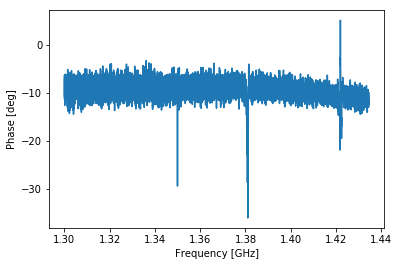

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

freq_avg=np.loadtxt(logpath+'contsrc_12h_phase.log',float,usecols=[0])
ph_avg=np.loadtxt(logpath+'contsrc_12h_phase.log',float,usecols=[1])
nchan=len(freq_avg)
plt.plot(freq_avg,ph_avg,'-')
plt.xlabel('Frequency [GHz]')
plt.ylabel('Phase [deg]')
plt.show()

Okay, now let's run uvspec with a shorter averaging interval and save the results to another log file, this time with a timestamp in it.  

In [29]:
uvspec = lib.miriad('uvspec')

uvspec.vis = uvfile
uvspec.interval = tint  #Averaging the calibrator over tint.
uvspec.stokes='ii'
uvspec.axis='frequency,phase'
uvspec.options='nobase,avall,timelog'
uvspec.log=logpath+'contsrc_tint_phase.log'
uvspec.offset=offsets

uvspec.go()

['UvSpec: version 1.0 21-Apr-10',
 'Applying bandpass corrections to /data4/pisano/m31/00/crosscal/M31.mir',
 'Applying gain corrections to /data4/pisano/m31/00/crosscal/M31.mir']

In [32]:
# First read the entire file into a string list
with open(logpath+'contsrc_tint_phase.log') as f:
    tmp_text=f.readlines()
f.close()

# Now write out each interval to a separate log file.

times=[]
interval=0
linecount=np.zeros([nint],int)
for t in range(len(tmp_text)-1):
    if ':' in tmp_text[t]:
        if interval!=0:
            f.close()
        f=open(logpath+"t{}.log".format(str(interval)),"w")
        times.append(tmp_text[t].rstrip())
        interval+=1   
    else:
        linecount[interval-1]+=1
        f.write(tmp_text[t])
f.close()

In [33]:
# Create ph_t array to hold each time interval in a separate row.  Initially they will be filled with zeros.
ph_t=np.zeros([nchan,nint],float)
ph_t.fill(np.nan)

# Now load the data from the log file into each row.
for t in range(nint):
    freq=np.loadtxt(logpath+'t{}.log'.format(str(t)),float,usecols=[0])
    ph=np.loadtxt(logpath+'t{}.log'.format(str(t)),float,usecols=[1])
    n=np.where(np.isin(freq_avg,freq))[0]
    ph_t[n,t]=ph


Okay, now we can plot these spectra and see how they compare.

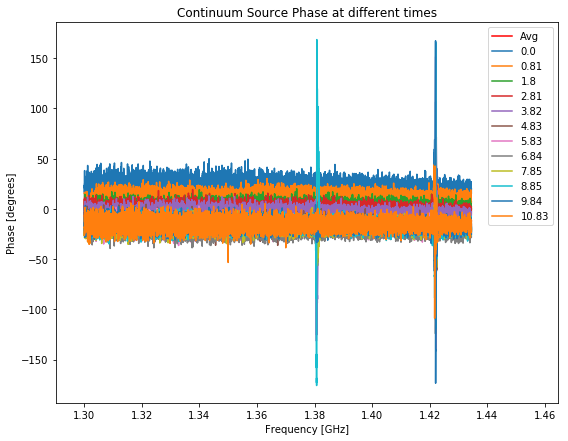

In [37]:
offset=0.2
plt.figure(figsize=(9,7))
plt.plot(freq_avg,ph_avg-offset,'r-',label='Avg')
for t in range(nint):
    plt.plot(freq_avg,ph_t[:,t]+t*offset,'-',label=round(t_mjd[t],2))
plt.xlim(np.min(freq_avg)-0.01,np.max(freq_avg)+0.03)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Phase [degrees]')
plt.title('Continuum Source Phase at different times')
plt.legend()
plt.show()

Now we will subtract the mean phases from each interval and plot that difference.

('Time interval: ', 0, 0.0, 'Mean phase difference: ', 31.75774270566417, '+/-', 8.006907580265612)
('Time interval: ', 1, 0.81, 'Mean phase difference: ', 21.39985664908849, '+/-', 5.203121650964321)
('Time interval: ', 2, 1.8, 'Mean phase difference: ', 11.372770283608002, '+/-', 4.56378846496862)
('Time interval: ', 3, 2.81, 'Mean phase difference: ', 8.256838347861894, '+/-', 4.507016808413489)
('Time interval: ', 4, 3.82, 'Mean phase difference: ', 3.627519666490245, '+/-', 7.132146271745791)
('Time interval: ', 5, 4.83, 'Mean phase difference: ', -6.638154943126724, '+/-', 5.922229356518717)
('Time interval: ', 6, 5.83, 'Mean phase difference: ', -9.503561518384904, '+/-', 6.437741070287619)
('Time interval: ', 7, 6.84, 'Mean phase difference: ', -13.566466224706346, '+/-', 5.416432589191721)
('Time interval: ', 8, 7.85, 'Mean phase difference: ', -9.929604802534488, '+/-', 4.795263542548094)
('Time interval: ', 9, 8.85, 'Mean phase difference: ', -8.328744852070358, '+/-', 11.34

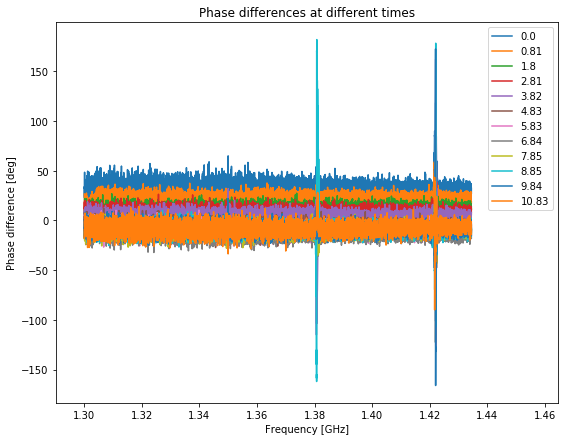

('The RMS of the phase differences (averaged over all channels) is: ', 13.813762447359615)


In [42]:
# Normalize by average amplitude of Flux calibrator to create ratio
ph_r=np.zeros([nchan,nint],float)
ph_r.fill(np.nan)

for t in range(nint):
    ph_r[:,t]=ph_t[:,t]-ph_avg[:]

# Calculate mean and stdev for each time interval
avg=[]
unc=[]
for t in range(nint):
    avg.append(np.nanmean(ph_r[:,t]))
    unc.append(np.nanstd(ph_r[:,t]))    
    print("Time interval: ",t,round(t_mjd[t],2),"Mean phase difference: ",avg[t],'+/-',unc[t])
    
# Plot each time interval
plt.figure(figsize=(9,7))
for t in range(nint):
    plt.plot(freq_avg,ph_r[:,t],label=round(t_mjd[t],2))
plt.xlim(np.min(freq_avg)-0.01,np.max(freq_avg)+0.03)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Phase difference [deg]')
plt.legend()
plt.title('Phase differences at different times')
plt.show()

print("The RMS of the phase differences (averaged over all channels) is: ",np.std(avg))

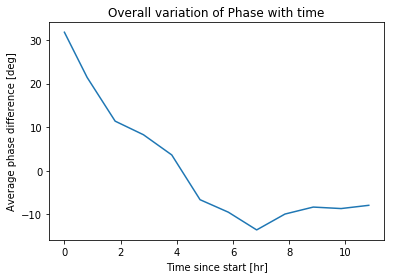

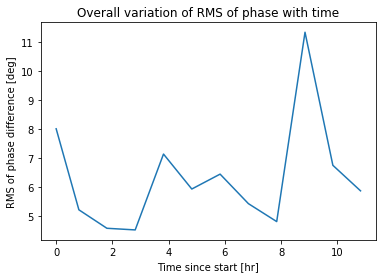

In [43]:
# Plot evolution of average phase difference and average rms with time
plt.plot(t_mjd,avg)
plt.xlabel('Time since start [hr]')
plt.ylabel('Average phase difference [deg]')
plt.title('Overall variation of Phase with time')
plt.show()

plt.plot(t_mjd,unc)
plt.xlabel('Time since start [hr]')
plt.ylabel('RMS of phase difference [deg]')
plt.title('Overall variation of RMS of phase with time')
plt.show()

In [44]:
# Divide the phases into the same chunks as the amplitudes

ph_ratio_bin=np.zeros([nchunk,nint],float)
ph_rms_bin=np.zeros([nchunk,nint],float)
# Now we will derive the average frequency and average ratio for each 9.3 MHz chunk
c1=0
c2=chanchunk
for i in range(nchunk):
    for t in range(nint):
        ph_ratio_bin[i,t]=np.nanmean(ph_r[c1:c2,t])
        ph_rms_bin[i,t]=np.nanstd(ph_r[c1:c2,t])

    c1+=chanchunk
    c2+=chanchunk

Okay, let's look at the phase difference as a function of both frequency and time:

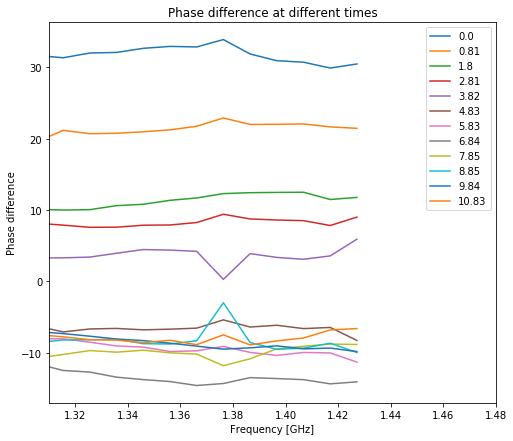

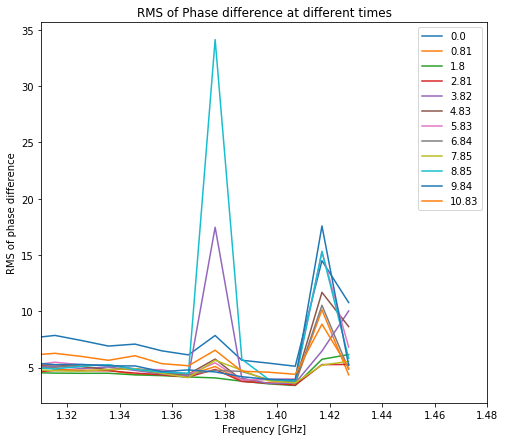

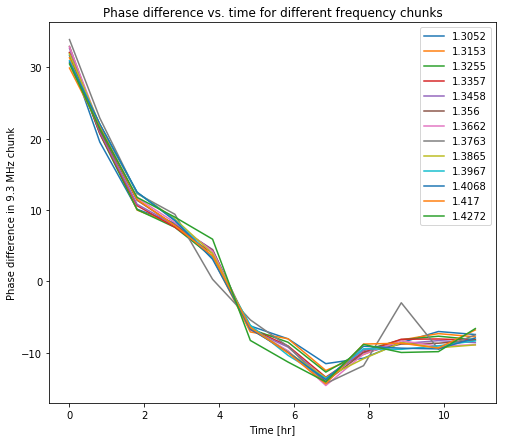

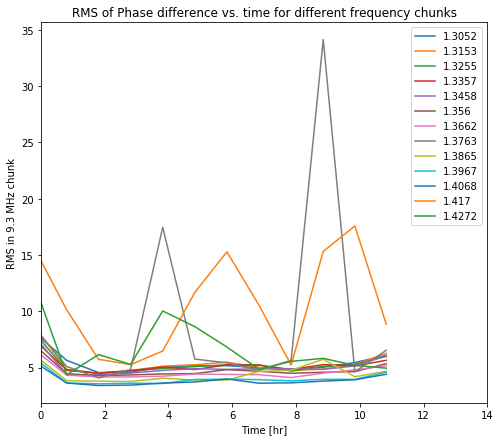

In [45]:
plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_bin,ph_ratio_bin[:,t],label=round(t_mjd[t],2))
plt.xlabel('Frequency [GHz]')
plt.ylabel('Phase difference')
plt.title('Phase difference at different times')
plt.xlim(1.31,1.48)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for t in range(nint):
    plt.plot(freq_bin,ph_rms_bin[:,t],label=round(t_mjd[t],2))
plt.xlabel('Frequency [GHz]')
plt.ylabel('RMS of phase difference')
plt.title('Phase spectrum at different times')
plt.title('RMS of Phase difference at different times')
plt.xlim(1.31,1.48)
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for c in range(nchunk):
    plt.plot(t_mjd,ph_ratio_bin[c,:],label=round(freq_bin[c],4))
plt.xlabel('Time [hr]')
plt.ylabel('Phase difference in 9.3 MHz chunk')
plt.title('Phase difference vs. time for different frequency chunks')
plt.legend()
plt.show()

plt.figure(figsize=(8,7))
for c in range(nchunk):
    plt.plot(t_mjd,ph_rms_bin[c,:],label=round(freq_bin[c],4))
plt.xlabel('Time [hr]')
plt.ylabel('RMS in 9.3 MHz chunk')
plt.title('RMS of Phase difference vs. time for different frequency chunks')
plt.xlim(0.,14.)
plt.legend()
plt.show()

In [46]:
# Calculate the RMS variation with time of each 10 MHz chunk
rms=[]
for c in range(nchunk):
    rms.append(np.std(ph_ratio_bin[c,:]))
    print('RMS variation of ratio in frequency chunk ',c,' is ',rms[c])

print('Mean RMS is ',np.mean(rms))


('RMS variation of ratio in frequency chunk ', 0, ' is ', 13.169302870913238)
('RMS variation of ratio in frequency chunk ', 1, ' is ', 13.375818637314481)
('RMS variation of ratio in frequency chunk ', 2, ' is ', 13.46467420788445)
('RMS variation of ratio in frequency chunk ', 3, ' is ', 13.654985341590082)
('RMS variation of ratio in frequency chunk ', 4, ' is ', 13.92056355988919)
('RMS variation of ratio in frequency chunk ', 5, ' is ', 14.123841466190424)
('RMS variation of ratio in frequency chunk ', 6, ' is ', 14.28250267920858)
('RMS variation of ratio in frequency chunk ', 7, ' is ', 14.424266498673763)
('RMS variation of ratio in frequency chunk ', 8, ' is ', 14.181067584235013)
('RMS variation of ratio in frequency chunk ', 9, ' is ', 13.944948441997067)
('RMS variation of ratio in frequency chunk ', 10, ' is ', 13.887535040860108)
('RMS variation of ratio in frequency chunk ', 11, ' is ', 13.521150937138382)
('RMS variation of ratio in frequency chunk ', 12, ' is ', 13.987